# Multimodal Brain Tumor Classification

## Setting up the Environment

In [15]:
# Import Python libraries
import os
import glob
import shutil
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sns
from tqdm.notebook import tqdm
import pydicom  as dicom
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, GlobalAveragePooling3D, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
from keras.metrics import AUC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from pydicom.pixel_data_handlers.util import apply_voi_lut

### Data Loading and Validating

In [16]:
# Paths of the dataset
input_path = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/"

In [17]:
train_labels_file = "train_labels.csv"
train_labels = pd.read_csv(
    input_path + train_labels_file)
train_labels.head(5)

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


## Exploratory Data Analysis(EDA)

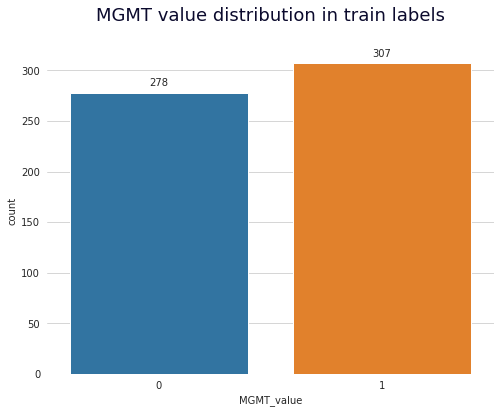

In [18]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(8,6))
# Countplot with Seaborn
ax = sns.countplot(data=train_labels,
                   x="MGMT_value")
# Annotating bars
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()),
        ha = 'center', va = 'center', 
        xytext = (0, 10), 
        textcoords = 'offset points')

sns.despine(left=True, bottom=True)
plt.title("MGMT value distribution in train labels\n",
          fontsize=18, color="#0b0a2d")
plt.show()

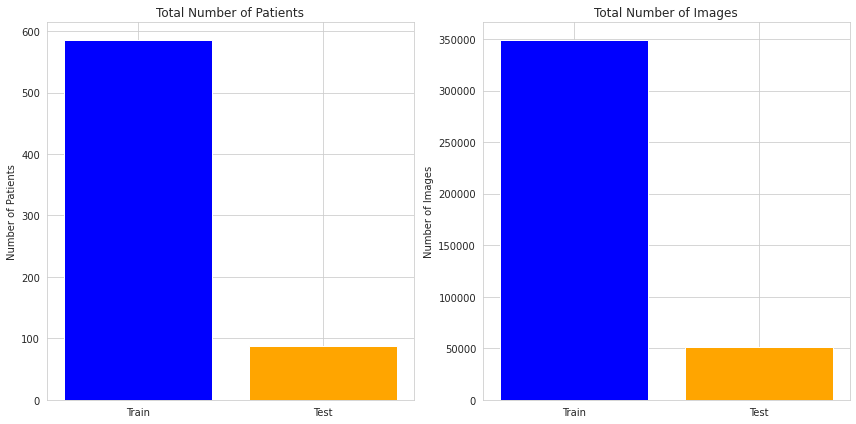

In [19]:
import os
import matplotlib.pyplot as plt

# Define the directory paths
train_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train"
test_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/test"

# Function to count patients and images
def count_patients_and_images(directory):
    patient_count = 0
    image_count = 0
    
    for patient_folder in os.listdir(directory):
        patient_path = os.path.join(directory, patient_folder)
        
        # Check if it's a folder
        if os.path.isdir(patient_path):
            patient_count += 1
            
            # Count images in each modality folder
            for modality in ["FLAIR", "T1w", "T1wCE", "T2w"]:
                modality_path = os.path.join(patient_path, modality)
                if os.path.isdir(modality_path):
                    image_count += len([img for img in os.listdir(modality_path) if img.endswith(".dcm")])

    return patient_count, image_count

# Get counts for training and testing sets
train_patients, train_images = count_patients_and_images(train_dir)
test_patients, test_images = count_patients_and_images(test_dir)

# Plotting the results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot for number of patients
ax[0].bar(["Train", "Test"], [train_patients, test_patients], color=["blue", "orange"])
ax[0].set_title("Total Number of Patients")
ax[0].set_ylabel("Number of Patients")

# Bar plot for number of images
ax[1].bar(["Train", "Test"], [train_images, test_images], color=["blue", "orange"])
ax[1].set_title("Total Number of Images")
ax[1].set_ylabel("Number of Images")

plt.tight_layout()
plt.show()

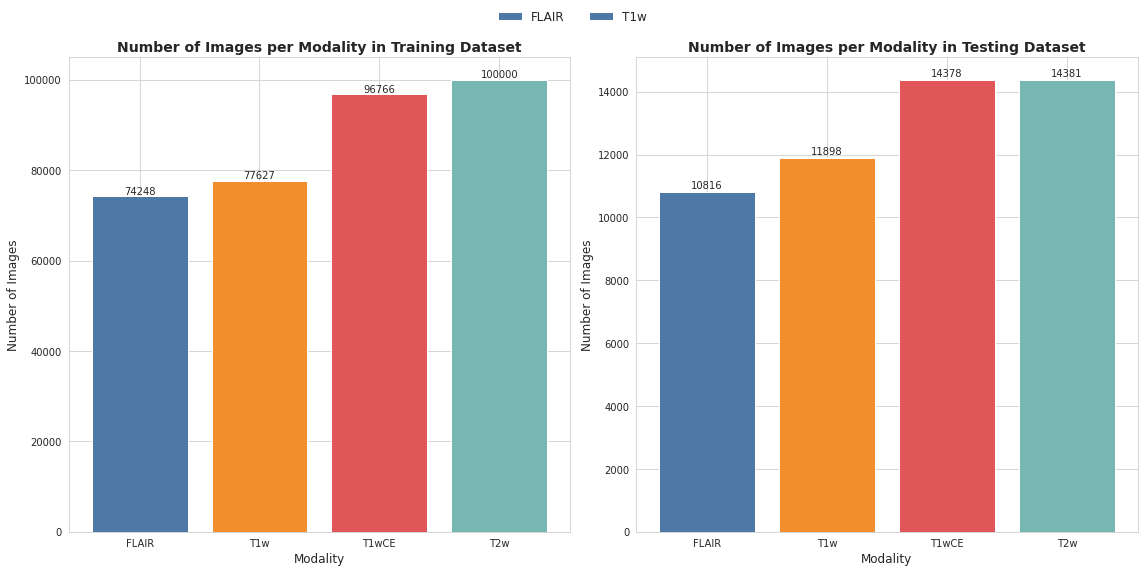

In [20]:
import os
import matplotlib.pyplot as plt

# Define the directory paths
train_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train"
test_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/test"

# Function to count images for each modality in each patient folder
def count_images_per_modality(directory):
    modalities = ["FLAIR", "T1w", "T1wCE", "T2w"]
    modality_counts = {modality: 0 for modality in modalities}
    
    for patient_folder in os.listdir(directory):
        patient_path = os.path.join(directory, patient_folder)
        
        # Check if it's a folder
        if os.path.isdir(patient_path):
            # Count images in each modality folder
            for modality in modalities:
                modality_path = os.path.join(patient_path, modality)
                if os.path.isdir(modality_path):
                    modality_counts[modality] += len([img for img in os.listdir(modality_path) if img.endswith(".dcm")])
    
    return modality_counts

# Get modality image counts for training and testing sets
train_modality_counts = count_images_per_modality(train_dir)
test_modality_counts = count_images_per_modality(test_dir)

# Plotting the results with improvements
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
colors = ["#4e79a7", "#f28e2b", "#e15759", "#76b7b2"]  # Different colors for each modality

# Bar plot for train dataset
ax[0].bar(train_modality_counts.keys(), train_modality_counts.values(), color=colors)
ax[0].set_title("Number of Images per Modality in Training Dataset", fontsize=14, weight='bold')
ax[0].set_xlabel("Modality", fontsize=12)
ax[0].set_ylabel("Number of Images", fontsize=12)

# Adding annotations to the bars
for i, (modality, count) in enumerate(train_modality_counts.items()):
    ax[0].text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10)

# Bar plot for test dataset
ax[1].bar(test_modality_counts.keys(), test_modality_counts.values(), color=colors)
ax[1].set_title("Number of Images per Modality in Testing Dataset", fontsize=14, weight='bold')
ax[1].set_xlabel("Modality", fontsize=12)
ax[1].set_ylabel("Number of Images", fontsize=12)

# Adding annotations to the bars
for i, (modality, count) in enumerate(test_modality_counts.items()):
    ax[1].text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10)

# Adding a legend
fig.legend(train_modality_counts.keys(), loc="upper center", ncol=4, fontsize=12, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for legend
plt.show()

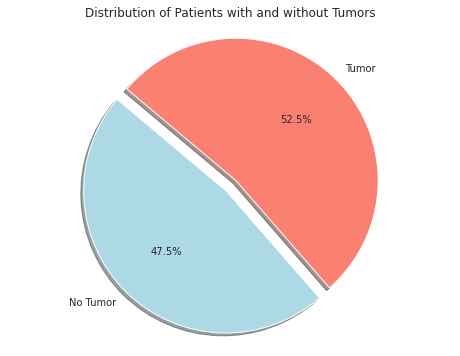

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Count the number of patients with and without tumors
tumor_counts = data['MGMT_value'].value_counts()

# Plotting
labels = ['No Tumor', 'Tumor']
sizes = [tumor_counts.get(0, 0), tumor_counts.get(1, 0)]  # Get counts for 0 and 1, default to 0 if not found
colors = ['lightblue', 'salmon']
explode = (0.1, 0)  # explode 1st slice (No Tumor)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Distribution of Patients with and without Tumors')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()

### Finding Missing Values

In [22]:
import os
import pandas as pd

# Define the directories and file paths
train_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train"
csv_path = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv"

# Load the CSV file
labels_df = pd.read_csv(csv_path)

# Process patient IDs to remove leading zeros and use the same format in both places
labels_df['BraTS21ID'] = labels_df['BraTS21ID'].apply(lambda x: str(x).zfill(5))

# Initialize lists for analysis data and skipped IDs
analysis_data = []
skipped_ids = []

# Function to count images in a given modality folder
def count_images_in_folder(folder_path):
    return len([img for img in os.listdir(folder_path) if img.endswith(".dcm")])

# Get all patient IDs from both CSV and folders for cross-referencing
all_patient_folders = set(os.listdir(train_dir))
all_csv_ids = set(labels_df['BraTS21ID'].values)

# Iterate through each patient folder in the training directory
for patient_folder in all_patient_folders:
    patient_id = patient_folder.zfill(5)  # Ensure ID format consistency

    # Check if the patient ID exists in the labels DataFrame
    if patient_id in all_csv_ids:
        # Find corresponding label for the patient
        label_row = labels_df[labels_df['BraTS21ID'] == patient_id]
        tumor_status = label_row['MGMT_value'].values[0]

        # Initialize counts for FLAIR and T1wCE
        flair_count, t1wce_count = 0, 0

        # Define paths for FLAIR and T1wCE folders
        flair_path = os.path.join(train_dir, patient_folder, "FLAIR")
        t1wce_path = os.path.join(train_dir, patient_folder, "T1wCE")

        # Count images if the folder exists and is not empty
        if os.path.isdir(flair_path):
            flair_count = count_images_in_folder(flair_path)
        if os.path.isdir(t1wce_path):
            t1wce_count = count_images_in_folder(t1wce_path)

        # Append the data to the analysis list
        analysis_data.append({
            "Patient ID": patient_id,
            "FLAIR Count": flair_count,
            "T1wCE Count": t1wce_count,
            "Tumor Status": "Yes" if tumor_status == 1 else "No"
        })
    else:
        # Record IDs skipped due to missing labels
        skipped_ids.append({"Patient ID": patient_id, "Reason": "No label in CSV"})

# Identify and record IDs from CSV with no corresponding image folder
for csv_id in all_csv_ids:
    if csv_id not in all_patient_folders:
        skipped_ids.append({"Patient ID": csv_id, "Reason": "No image folder in train directory"})

# Create DataFrames to display analysis data and skipped IDs
analysis_df = pd.DataFrame(analysis_data)
skipped_ids_df = pd.DataFrame(skipped_ids)

# Display the tables
print("Analysis Table:")
print(analysis_df)

# Check if there are any skipped IDs
if skipped_ids:
    print("\nSkipped IDs Table:")
    print(skipped_ids_df)
else:
    print("\nNo missing data found. All patient IDs have corresponding labels and image folders.")

Analysis Table:
    Patient ID  FLAIR Count  T1wCE Count Tumor Status
0        00750          212          180          Yes
1        00249           60          192           No
2        00367           60           68          Yes
3        00017          129          328           No
4        00338           60           32          Yes
..         ...          ...          ...          ...
580      00589           24           24           No
581      00191           60          192           No
582      00630          168          180           No
583      00350           32          192          Yes
584      00233           60          192          Yes

[585 rows x 4 columns]

No missing data found. All patient IDs have corresponding labels and image folders.


In [23]:
import pydicom

In [24]:
import os
import pandas as pd
from IPython.display import display, HTML

# Define the directories and file paths
train_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train"
csv_path = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv"

# Load the CSV file
labels_df = pd.read_csv(csv_path)

# Process patient IDs to remove leading zeros and use consistent format in both sources
labels_df['BraTS21ID'] = labels_df['BraTS21ID'].apply(lambda x: str(x).zfill(5))

# Initialize lists for analysis data and skipped IDs
analysis_data = []
skipped_ids = []

# Function to count images in a given modality folder
def count_images_in_folder(folder_path):
    return len([img for img in os.listdir(folder_path) if img.endswith(".dcm")])

# Get all patient IDs from both CSV and folders for cross-referencing
all_patient_folders = set(os.listdir(train_dir))
all_csv_ids = set(labels_df['BraTS21ID'].values)

# Iterate through each patient folder in the training directory
for patient_folder in all_patient_folders:
    patient_id = patient_folder.zfill(5)  # Ensure consistent ID format

    # Check if the patient ID exists in the labels DataFrame
    if patient_id in all_csv_ids:
        # Retrieve tumor status for the patient
        tumor_status = labels_df.loc[labels_df['BraTS21ID'] == patient_id, 'MGMT_value'].values[0]

        # Initialize counts for FLAIR and T1wCE
        flair_count, t1wce_count = 0, 0

        # Define paths for FLAIR and T1wCE folders
        flair_path = os.path.join(train_dir, patient_folder, "FLAIR")
        t1wce_path = os.path.join(train_dir, patient_folder, "T1wCE")

        # Count images if folders exist and are not empty
        if os.path.isdir(flair_path):
            flair_count = count_images_in_folder(flair_path)
        if os.path.isdir(t1wce_path):
            t1wce_count = count_images_in_folder(t1wce_path)

        # Append formatted data for the analysis table
        analysis_data.append({
            "Patient ID": patient_id,
            "FLAIR Count": flair_count,
            "T1wCE Count": t1wce_count,
            "Tumor Status": "Yes" if tumor_status == 1 else "No"
        })
    else:
        # Record IDs skipped due to missing labels
        skipped_ids.append({"Patient ID": patient_id, "Reason": "No label in CSV"})

# Identify and record IDs from CSV with no corresponding image folder
for csv_id in all_csv_ids:
    if csv_id not in all_patient_folders:
        skipped_ids.append({"Patient ID": csv_id, "Reason": "No image folder in train directory"})

# Create DataFrames for analysis and skipped IDs tables
analysis_df = pd.DataFrame(analysis_data)
skipped_ids_df = pd.DataFrame(skipped_ids)

# Sort the analysis DataFrame by 'Patient ID' in ascending order
analysis_df = analysis_df.sort_values(by="Patient ID").reset_index(drop=True)

# Add a numbering column to the analysis table
analysis_df.index = range(1, len(analysis_df) + 1)
analysis_df.index.name = "Entry Number"

# Display the tables with enhanced formatting
print("\n--- Analysis Table ---\n")
if not analysis_df.empty:
    # Center-align the table content and make it wider for improved readability
    display(HTML(analysis_df.to_html(index=True, justify='center', border=1)))

train_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
images = load_dicom_images("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR")

# Check if there are any skipped IDs and display accordingly
if skipped_ids:
    print("\n--- Skipped IDs Table ---\n")
    # Sort skipped IDs by 'Patient ID' and apply similar formatting
    skipped_ids_df = skipped_ids_df.sort_values(by="Patient ID").reset_index(drop=True)
    skipped_ids_df.index = range(1, len(skipped_ids_df) + 1)
    skipped_ids_df.index.name = "Entry Number"
    display(HTML(skipped_ids_df.to_html(index=True, justify='center', border=1)))
else:
    print("\nNo missing data found. All patient IDs have corresponding labels and image folders.")


--- Analysis Table ---



,Patient ID,FLAIR Count,T1wCE Count,Tumor Status
Entry Number,,,,
1,00000,400,129,Yes
2,00002,129,129,Yes
3,00003,129,129,No
4,00005,400,129,Yes
5,00006,129,129,Yes
6,00008,168,150,Yes
7,00009,240,360,No
8,00011,129,129,Yes
9,00012,400,304,Yes


NameError: name 'load_dicom_file' is not defined

## Data Preprocessing

In [ ]:
def load_dicom_images(path):
    """
    Loads a sequence of DICOM images from a directory.

    Args:
    - path: The path to the directory containing the DICOM files.

    Returns:
    - A list of 2D arrays representing the DICOM images.
    """
    # Get the paths to the DICOM files and sort them by slice number
    dicom_paths = sorted(
        glob.glob(os.path.join(path, "*")), 
        key=lambda x: int(x[:-4].split("-")[-1]),
    )

    # Load the DICOM images into a list
    images = []
    for path in dicom_paths:
        image = load_dicom_file(path)
        if image.max() != 0:
            images.append(image)

    return images

In [ ]:
# Define a function to load DICOM files
def load_dicom_file(path):
    dicom_file = pydicom.read_file(path)
    pixel_array = dicom_file.pixel_array
    pixel_array = pixel_array - np.min(pixel_array)
    if np.max(pixel_array) != 0:
        pixel_array = pixel_array / np.max(pixel_array)
    pixel_array = (pixel_array * 255).astype(np.uint8)
    return pixel_array

## Skull Stripping

In [ ]:
import SimpleITK as sitk
from PIL import Image
import numpy as np

# Function to perform skull stripping
def skull_strip(input_image_path):
    # Read the DICOM image
    image = sitk.ReadImage(input_image_path)

    # Brain mask creation using Otsu thresholding
    brain_mask = sitk.OtsuThreshold(image, 0, 1)

    # Fill holes in the mask to improve the mask
    brain_mask = sitk.BinaryFillhole(brain_mask)

    # Apply the mask to the original image
    skull_stripped_image = sitk.Mask(image, brain_mask)

    return skull_stripped_image

# Preprocessing pipeline
def preprocess_image(image_path):
    # Perform skull stripping
    skull_stripped_image = skull_strip(image_path)

    # Convert the image to a NumPy array
    pixel_array = sitk.GetArrayFromImage(skull_stripped_image)

    # Normalize pixel values to [0, 1]
    pixel_array = pixel_array / np.max(pixel_array)

    # Convert to a 2D image (assuming single slice for simplicity)
    if len(pixel_array.shape) > 2:
        pixel_array = pixel_array[0]  # Take the first slice if it's a 3D image

    # Resize the image to (256, 256) using PIL
    image = Image.fromarray((pixel_array * 255).astype(np.uint8))
    image = image.resize((256, 256), Image.LANCZOS)  # Correct resampling method

    return np.array(image)

# Example usage
image_path = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR/Image-121.dcm"  # Replace with your image path
processed_image = preprocess_image(image_path)

# Display or analyze the processed image
print("Processed Image Shape:", processed_image.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(processed_image, cmap="gray")
plt.title("Processed Image")
plt.show()

Skull stripping is a process where non-brain tissues such as the skull, scalp, and other surrounding regions are removed from an image, leaving only the brain structure. In this image, the brain is isolated, and there are no visible outer skull structures or surrounding tissues.

In [ ]:
from pathlib import Path

def plot_brain_3d(directory):
    # Load all DICOM files in the directory
    files = sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')], key=lambda path: int(os.path.splitext(os.path.basename(path))[0].split('-')[-1]))

    print("File count: {}".format(len(files)))

    # Load the DICOM files into memory and skip those with no SliceLocation attribute
    slices = []
    skipcount = 0
    for fname in files:
        ds = pydicom.dcmread(fname)
        if hasattr(ds, 'SliceLocation'):
            slices.append(ds)
        else:
            skipcount += 1
    print("Skipped, no SliceLocation: {}".format(skipcount))

    # Sort the slices based on their SliceLocation attribute
    slices = sorted(slices, key=lambda s: s.SliceLocation)

    # Calculate pixel aspect ratios for each view
    ps = slices[0].PixelSpacing
    ss = slices[0].SliceThickness
    ax_aspect = ps[1]/ps[0]
    sag_aspect = ps[1]/ss
    cor_aspect = ss/ps[0]

    # Create a 3D array to store the image data
    img_shape = list(slices[0].pixel_array.shape)
    img_shape.append(len(slices))
    img3d = np.zeros(img_shape)

    # Fill the 3D array with the pixel data from each slice
    for i, s in enumerate(slices):
        img2d = s.pixel_array
        img3d[:, :, i] = img2d

    # Plot the 3 orthogonal views
    fig, axes = plt.subplots(1, 3, figsize=(25, 25))
    fig.suptitle("Brain CT Scan in three different views (Horizontal, Sagittal, Coronal)", fontsize=24)

    axes[0].imshow(img3d[:, :, img_shape[2]//2], cmap='hot')
    axes[0].set_aspect(ax_aspect)

    axes[1].imshow(img3d[:, img_shape[1]//2, :], cmap='hot')
    axes[1].set_aspect(sag_aspect)

    axes[2].imshow(img3d[img_shape[0]//2, :, :].T, cmap='hot')
    axes[2].set_aspect(cor_aspect)

    plt.show()

# Example usage: plot 3D brain scans in the directory '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00006/FLAIR/'
directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00006/FLAIR/'
plot_brain_3d(directory)

In [ ]:
os.listdir('/kaggle/input/')
mri_types = ["FLAIR", "T1w", "T2w", "T1wCE"]
threshold = 10
exc = [109, 123, 709]
train_df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
test_df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")
train_df = train_df[~train_df.BraTS21ID.isin(exc)]

In [ ]:
def crop_resize_img(img, scale=1.0, dim=(244,244)): 
    '''
    Crop function to keep a central part of the 2D image 
    according to a defined scale and resize it to 
    specific dimension.
    ****************************************************
    PARAMETERS
    ****************************************************
    - img : 2D array
        2D array of pixels in the image
    - scale : float
        Desired scale of the cropped image
    - dim : Tuple
        Tuple of integer with desired final width, height
    '''
    # Crop image
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    
    # Resize
    img_cropped = cv2.resize(img_cropped, dim, interpolation = cv2.INTER_AREA)
    return img_cropped

## Normalization

In [44]:
# Dicom image, standardizes so that pixel values are between 0 and 1
# Rescale to 0 and 255
def dicomImage(path, size = 224):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.resize(data, (size, size))

# Returns an arry of all the images of a particular type for a particular patient ID
def allImagePath(brats21id, image_type, folder='train'): 
    assert(image_type in mri_types)
    
    patient_path = os.path.join(
        "../input/rsna-miccai-brain-tumor-radiogenomic-classification/%s/" % folder, 
        str(brats21id).zfill(5),
    )

    paths = sorted(
        glob.glob(os.path.join(patient_path, image_type, "*")), 
        key=lambda x: int(x[:-4].split("-")[-1]),
    )
    
    num_images = len(paths)
    
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)

    interval = 3
    
    if num_images < 10: 
        interval = 1
    
    return np.array(paths[start:end:interval])

def get_all_images(brats21id, image_type, folder='train', size=225):
    return [dicomImage(path, size) for path in allImagePath(brats21id, image_type, folder)]

In [1]:
imgaeSize = 128  ### Suggested 224, Learning Curve(train vs test/loss and accuracy), XAI, Test Size=0.2, Comparison Original and Preprocessed Image

def get_all_data_for_train_all_modalities(modalities, size=128):
    global train_df
    var1 = []
    var2 = []
    train_ids = []

    for i in tqdm(train_df.index):
        x = train_df.loc[i]
        patient_images = []

        for modality in modalities:
            # Load all images for this modality
            images = get_all_images(int(x['BraTS21ID']), modality, 'train', size)
            patient_images.append(images)

        # Stack images across the channel axis (axis=-1)
        stacked_images = np.stack(patient_images, axis=-1)

        label = x['MGMT_value']
        var1 += list(stacked_images)
        var2 += [label] * stacked_images.shape[0]
        train_ids += [int(x['BraTS21ID'])] * stacked_images.shape[0]
        assert(len(var1) == len(var2))

    return np.array(var1), np.array(var2), np.array(train_ids)


def get_all_data_for_test_all_modalities(modalities, size=128):
    global test_df
    var1 = []
    test_ids = []

    for i in tqdm(test_df.index):
        x = test_df.loc[i]
        patient_images = []

        for modality in modalities:
            # Load all images for this modality
            images = get_all_images(int(x['BraTS21ID']), modality, 'test', size)
            patient_images.append(images)

        # Stack images across the channel axis (axis=-1)
        stacked_images = np.stack(patient_images, axis=-1)

        var1 += list(stacked_images)
        test_ids += [int(x['BraTS21ID'])] * stacked_images.shape[0]

    return np.array(var1), np.array(test_ids)

## Fusion of input data

In [59]:
def get_fused_images(brats21id, size=224):
    # Get images of different types
    flair_images = get_all_images(brats21id, "FLAIR", 'train', size)
    t1w_images = get_all_images(brats21id, "T1w", 'train', size)
    t2w_images = get_all_images(brats21id, "T2w", 'train', size)
    t1wce_images = get_all_images(brats21id, "T1wCE", 'train', size)
    
    # Stack them along the channel axis to create a 4-channel image
    fused_images = []
    for f, t1, t2, t1ce in zip(flair_images, t1w_images, t2w_images, t1wce_images):
        fused_image = np.stack([f, t1, t2, t1ce], axis=-1)  # stack along the last axis (channel axis)
        fused_images.append(fused_image)
    
    return np.array(fused_images)

# Usage of the ID 109 to check the Fused Images
fused_images1 = get_fused_images(109, size=224)
print(fused_images1.shape)

(4, 224, 224, 4)


In [60]:
# Another Check
fused_images2 = get_fused_images(110, size=224)
print(fused_images2.shape)

(4, 224, 224, 4)


In [62]:
# X, Y, train_idt = get_all_data_for_train('T2w')
# X_test, test_idt = get_all_data_for_test('T2w')
# X.shape, Y.shape, train_idt.shape, test_idt.shape

  0%|          | 0/582 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

((16813, 128, 128), (16813,), (16813,), (2428,))

In [3]:
from tqdm import tqdm

In [5]:
import pandas as pd

# Load the training dataset
train_df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
exc = [109, 123, 709]
train_df = train_df[~train_df.BraTS21ID.isin(exc)]

In [7]:
import os
import numpy as np
import pandas as pd
import cv2
import glob
import pydicom
from tqdm import tqdm

# Define modalities and load training data
mri_types = ["FLAIR", "T1w", "T2w", "T1wCE"]
train_df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
exc = [109, 123, 709]
train_df = train_df[~train_df.BraTS21ID.isin(exc)]

# Call function with all modalities
X, Y, train_idt = get_all_data_for_train_all_modalities(mri_types, size=128)
X_test, test_idt = get_all_data_for_test_all_modalities(mri_types, size=128)

print(X.shape, Y.shape, train_idt.shape)
print(X_test.shape, test_idt.shape)

  0%|          | 0/582 [00:00<?, ?it/s]


NameError: name 'get_all_images' is not defined

In [6]:
mri_types = ["FLAIR", "T1w", "T2w", "T1wCE"]

# Load training and test data
X, Y, train_idt = get_all_data_for_train_all_modalities(mri_types, size=128)
X_test, test_idt = get_all_data_for_test_all_modalities(mri_types, size=128)

# Check the shape
print(X.shape, Y.shape, train_idt.shape)
print(X_test.shape, test_idt.shape)

  0%|          | 0/582 [00:00<?, ?it/s]


NameError: name 'get_all_images' is not defined

In [8]:
def dicomImage(path, size=224):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.resize(data, (size, size))

def allImagePath(brats21id, image_type, folder='train'): 
    assert(image_type in mri_types)
    
    patient_path = os.path.join(
        "../input/rsna-miccai-brain-tumor-radiogenomic-classification/%s/" % folder, 
        str(brats21id).zfill(5),
    )

    paths = sorted(
        glob.glob(os.path.join(patient_path, image_type, "*")), 
        key=lambda x: int(x[:-4].split("-")[-1]),
    )
    
    num_images = len(paths)
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)
    interval = 3
    if num_images < 10: 
        interval = 1
    return np.array(paths[start:end:interval])

def get_all_images(brats21id, image_type, folder='train', size=224):
    return [dicomImage(path, size) for path in allImagePath(brats21id, image_type, folder)]


In [9]:
import os
import numpy as np
import pandas as pd
import cv2
import glob
import pydicom
from tqdm import tqdm

# Define modalities
mri_types = ["FLAIR", "T1w", "T2w", "T1wCE"]

# Load training data
train_df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
exc = [109, 123, 709]
train_df = train_df[~train_df.BraTS21ID.isin(exc)]

# Define helper functions
def dicomImage(path, size=224):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.resize(data, (size, size))

def allImagePath(brats21id, image_type, folder='train'): 
    assert(image_type in mri_types)
    patient_path = os.path.join(
        "../input/rsna-miccai-brain-tumor-radiogenomic-classification/%s/" % folder, 
        str(brats21id).zfill(5),
    )
    paths = sorted(
        glob.glob(os.path.join(patient_path, image_type, "*")), 
        key=lambda x: int(x[:-4].split("-")[-1]),
    )
    num_images = len(paths)
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)
    interval = 3
    if num_images < 10: 
        interval = 1
    return np.array(paths[start:end:interval])

def get_all_images(brats21id, image_type, folder='train', size=224):
    return [dicomImage(path, size) for path in allImagePath(brats21id, image_type, folder)]

# Define modality-based data loader
def get_all_data_for_train_all_modalities(modalities, size=224):
    global train_df
    var1 = []
    var2 = []
    train_ids = []

    for i in tqdm(train_df.index):
        x = train_df.loc[i]
        patient_images = []
        for modality in modalities:
            images = get_all_images(int(x['BraTS21ID']), modality, 'train', size)
            patient_images.append(images)
        var1.append(np.stack(patient_images, axis=-1))  # Fuse modalities into the channel axis
        var2.append(x['MGMT_value'])
        train_ids.append(int(x['BraTS21ID']))
    return np.array(var1), np.array(var2), np.array(train_ids)

def get_all_data_for_test_all_modalities(modalities, size=224):
    global test_df
    var1 = []
    test_ids = []

    for i in tqdm(test_df.index):
        x = test_df.loc[i]
        patient_images = []
        for modality in modalities:
            images = get_all_images(int(x['BraTS21ID']), modality, 'test', size)
            patient_images.append(images)
        var1.append(np.stack(patient_images, axis=-1))  # Fuse modalities into the channel axis
        test_ids.append(int(x['BraTS21ID']))
    return np.array(var1), np.array(test_ids)

# Load training and test data
X, Y, train_idt = get_all_data_for_train_all_modalities(mri_types, size=128)
X_test, test_idt = get_all_data_for_test_all_modalities(mri_types, size=128)

print(X.shape, Y.shape, train_idt.shape)
print(X_test.shape, test_idt.shape)

  0%|          | 0/582 [00:01<?, ?it/s]


ValueError: all input arrays must have the same shape

In [51]:
X_train, X_valid, y_train, y_valid, trainidt_train, trainidt_valid = train_test_split(X, Y, train_idt, test_size=0.1, random_state=140)
split = int(X.shape[0] * 0.9)

In [ ]:
X_train = tf.expand_dims(X_train, axis = -1)
X_valid = tf.expand_dims(X_valid, axis = -1)

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

In [ ]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, trainidt_train.shape, trainidt_valid.shape

In [ ]:
import random

In [ ]:
np.random.seed(0)
random.seed(12)
tf.random.set_seed(12)

inputShape = keras.Input(shape = X_train.shape[1:])

preProcessing = keras.layers.experimental.preprocessing.Rescaling(1./255)(inputShape)
# h = augmentation(h)

# convolutional layer!
l = keras.layers.Conv2D(32, kernel_size=(3, 3),strides=(1,1), activation="relu", name="Conv_1", padding="valid")(preProcessing) 
l = tf.keras.layers.BatchNormalization(axis=-1)(l)
l = keras.layers.Conv2D(32, kernel_size=(3, 3),strides=(1,1), activation="relu", name="Conv_1b", padding="same")(l) 
l = tf.keras.layers.BatchNormalization(axis=-1)(l)
l = keras.layers.MaxPool2D(pool_size=(2,2))(l)
l = keras.layers.Conv2D(64, kernel_size=(3, 3),strides=(1,1), activation="relu", name="Conv_2", padding="valid")(l) 
l = tf.keras.layers.BatchNormalization(axis=-1)(l)

# pooling layer
l = keras.layers.MaxPool2D(pool_size=(2,2))(l)
l = tf.keras.layers.BatchNormalization(axis=-1)(l)

# convolutional layer!
l = keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", name="Conv_3",padding ="same")(l)

# pooling layer
l = tf.keras.layers.BatchNormalization(axis=-1)(l)
l = keras.layers.Dropout(0.4)(l)
l = keras.layers.Flatten()(l)
l1 = keras.layers.experimental.preprocessing.Rescaling(1./255)(preProcessing)
l1 =  keras.layers.MaxPool2D(strides=(5,5))(l1)
l1 = keras.layers.Conv2D(32, kernel_size=(3, 3), activation="swish", name="Conv_4b")(l1)
l1 = tf.keras.layers.BatchNormalization(axis=-1)(l1)
l1 =  keras.layers.MaxPool2D(strides=(5,5))(l1)
l1 = keras.layers.Dropout(0.3)(l1)
l1 = keras.layers.Conv2D(32, kernel_size=(3, 3), activation="swish", name="Conv_5b")(l1)
l1 = tf.keras.layers.BatchNormalization(axis=-1)(l1)
l1 =  keras.layers.MaxPool2D(strides=(5,5))(l1)
l1 = keras.layers.Dropout(0.3)(l1)
l1 = keras.layers.Flatten()(l1)

## feature-level fusion

In [ ]:
merge = keras.layers.Concatenate()([l,l1])
dropOut = keras.layers.Dropout(0.4)(merge)
dropOut = keras.layers.Dense(150, activation='relu')(dropOut)  
outPut = keras.layers.Dense(2, activation="softmax")(dropOut)

In [ ]:
model = keras.Model(inputShape, outPut)

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
from keras.optimizers import SGD

filepathCheckpoint = 'cnn_model.h5'

modelCallbackCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepathCheckpoint,
    save_weights_only = False,
    monitor = 'val_auc',
    mode = 'max',
    save_best_only = True,
    save_freq = 'epoch'
)

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(learning_rate =0.0001),
    metrics = [tf.keras.metrics.AUC()]
)

history = model.fit(x = X_train, y = y_train, epochs = 100, callbacks = [modelCallbackCheckpoint], validation_data = (X_valid, y_valid))

In [ ]:
model1 = tf.keras.models.load_model(filepath = filepathCheckpoint)

In [ ]:
y_pred = model1.predict(X_valid)

pred = np.argmax(y_pred, axis = 1)

result = pd.DataFrame(trainidt_valid)
result[1] = pred

result.columns = ['BraTS21ID','MGMT_value']
result2 = result.groupby('BraTS21ID', as_index = False).mean()

result2 = result2.merge(train_df, on = 'BraTS21ID')
roc_auc_score(result2.MGMT_value_y, result2.MGMT_value_x,)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get true labels and predicted probabilities
y_true = result2.MGMT_value_y  # Ground truth from the dataset
y_pred_probs = result2.MGMT_value_x  # Predicted probabilities (averaged)

# Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Calculate AUC (Area Under Curve)
auc_score = roc_auc_score(y_true, y_pred_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='b')
plt.plot([0, 1], [0, 1], 'r--', label="Random Guess (AUC = 0.5)")

# Add labels, title, and legend
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Explainable AI

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from lime import lime_image
from skimage.segmentation import mark_boundaries
import pydicom
from skimage.transform import resize

# Load the model
model = load_model("/kaggle/working/Brain_3d_multimodal.h5")  # Replace with your model path


def load_and_preprocess_dicom(img_path, target_size=(120, 120, 24)):
    """
    Load a DICOM file, preprocess it for 3D CNN input, and return a tensor.
    """
    dicom = pydicom.dcmread(img_path)
    img = dicom.pixel_array.astype(np.float32)  # Extract pixel array and ensure float32

    # Check if max value is zero to avoid division by zero
    img_max = np.max(img)
    if img_max != 0:
        img = img / img_max  # Normalize to [0, 1]
    else:
        img = np.zeros_like(img)  # Or you can choose to keep img as zero array or use default values

    # Resize the image to the target shape
    img_resized = resize(img, target_size, anti_aliasing=True)

    # Add channel and batch dimensions
    img_resized = np.expand_dims(img_resized, axis=-1)  # Add channel dimension
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension

    return img_resized


# Prepare 4 inputs (replace paths with actual DICOM file paths)
input_1 = load_and_preprocess_dicom("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/test/00013/FLAIR/Image-387.dcm")  # Replace with actual file
input_2 = load_and_preprocess_dicom("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/test/00013/T1w/Image-1.dcm")
input_3 = load_and_preprocess_dicom("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/test/00013/T1wCE/Image-1.dcm")
input_4 = load_and_preprocess_dicom("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/test/00013/T2w/Image-1.dcm")

# Model prediction
inputs = [input_1, input_2, input_3, input_4]  # Combine all inputs as a list
preds = model.predict(inputs)
predicted_class = np.argmax(preds[0]) if preds.shape[-1] > 1 else (preds[0] > 0.5).astype(int)

print(f"Predicted Class: {predicted_class}")